# GCA for Link prediction

In [14]:
# import
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import LineGraph
import networkx as nx
import torch
import numpy as np
import random

from torch_geometric.datasets import KarateClub, TUDataset, AttributedGraphDataset
from torch_geometric.utils import dropout_adj, degree, to_undirected
from simple_param.sp import SimpleParam
from pGRACE.model import Encoder, GRACE
from pGRACE.functional import drop_feature, drop_edge_weighted, \
    degree_drop_weights, \
    evc_drop_weights, pr_drop_weights, \
    feature_drop_weights, drop_feature_weighted_2, feature_drop_weights_dense
from pGRACE.eval import log_regression, MulticlassEvaluator
from pGRACE.utils import get_base_model, get_activation, \
    generate_split, compute_pr, eigenvector_centrality
from train import train, test

## Dataset load

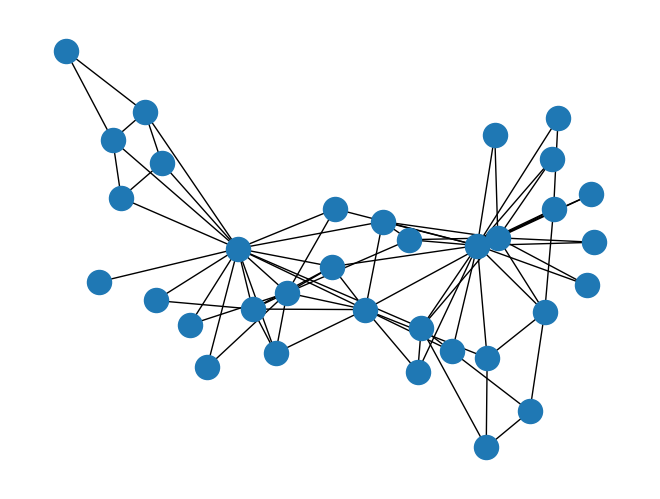

In [15]:
karate_dataset = KarateClub()
karate = karate_dataset[0]
karatex = to_networkx(karate)
karatex = karatex.to_undirected()
karate
nx.draw(karatex)

Data(edge_index=[2, 146], y=[1], num_nodes=20)


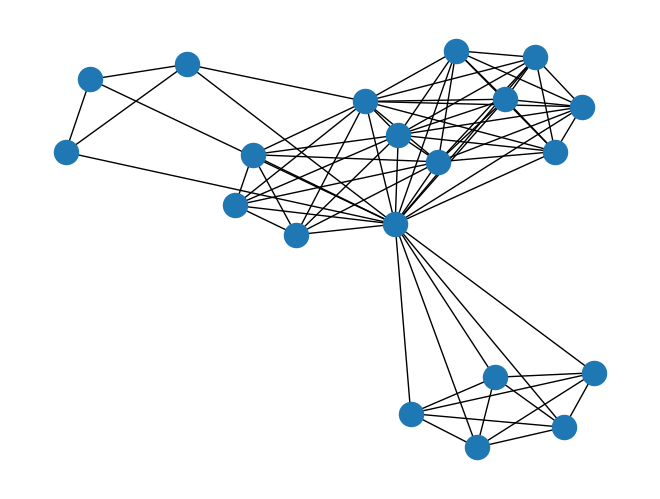

In [ ]:
tu_dataset = TUDataset('./dataset', "IMDB-BINARY")
imdb = tu_dataset[0]
imdbx = to_networkx(imdb)
imdbx = imdbx.to_undirected()
print(imdb)
nx.draw(imdbx)

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])


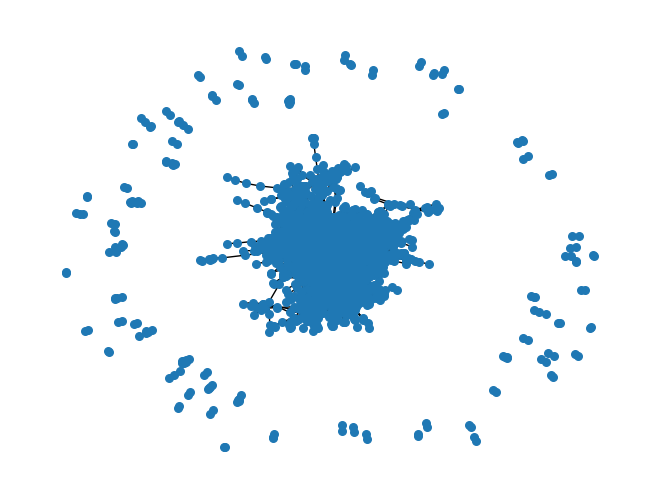

In [18]:
attr_graph_dataset = AttributedGraphDataset('./dataset', "Cora")
cora = attr_graph_dataset[0]
corax = to_networkx(cora)
corax = corax.to_undirected()
print(cora)
nx.draw(corax, node_size=30)

In [24]:
G = cora
dataset = attr_graph_dataset

## LineGraph

In [ ]:
def to_linegraph(graph: Data):
	graph = graph.clone()
	num_edges = graph.num_edges
	# on construit le line graph avec 50% de negative edge et 50% de positive edge
	neg_edge_index = negative_sampling(graph.edge_index)
	graph.edge_index = torch.cat((graph.edge_index, neg_edge_index), -1)
	src_nodes = graph.edge_index[0]
	target_nodes = graph.edge_index[1]
	edge_attr = graph.x[src_nodes] + graph.x[target_nodes] # aggregation des attributs de noeuds
	graph.edge_attr = edge_attr
	linegraph = LineGraph()(graph)
	linegraph.y = torch.tensor(np.concatenate((np.zeros(num_edges), np.ones(num_edges)))) # label la moitier son vrai, l'autre neg
	print(linegraph)
	return linegraph

In [22]:
LG = to_linegraph(G)
LGx = to_networkx(LG)
LGx = LGx.to_undirected()
# nx.draw(LGx, node_size=30)

## GCA on LG

In [23]:
param = {
        'learning_rate': 0.01,
        'num_hidden': 256,
        'num_proj_hidden': 32,
        'activation': 'prelu',
        'base_model': 'GCNConv',
        'num_layers': 2,
        'drop_edge_rate_1': 0.3,
        'drop_edge_rate_2': 0.4,
        'drop_feature_rate_1': 0.1,
        'drop_feature_rate_2': 0.0,
        'tau': 0.4,
        'num_epochs': 300,
        'weight_decay': 1e-5,
        'drop_scheme': 'degree',
    }
torch.manual_seed(12345)
random.seed(12345)

In [25]:
split = generate_split(LG.num_nodes, train_ratio=0.1, val_ratio=0.1) # generic train test split

encoder = Encoder(dataset.num_features, param['num_hidden'], get_activation(param['activation']),
					base_model=get_base_model(param['base_model']), k=param['num_layers'])
model = GRACE(encoder, param['num_hidden'], param['num_proj_hidden'], param['tau']) # init the model
optimizer = torch.optim.Adam(
	model.parameters(),
	lr=param['learning_rate'],
	weight_decay=param['weight_decay']
)
drop_weights = degree_drop_weights(LG.edge_index)
edge_index_ = to_undirected(LG.edge_index)
node_deg = degree(edge_index_[1])
feature_weights = feature_drop_weights(LG.x, node_c=node_deg)

/home/sycosma/.conda/envs/p310/lib/python3.10/site-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'GCNConv.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "


In [26]:
for epoch in range(1, param['num_epochs'] + 1):
	loss = train(model, optimizer, LG, drop_weights, feature_weights, param)
	if epoch % 1 == 0:
		print(f'(T) | Epoch={epoch:03d}, loss={loss:.4f}')

	if epoch % 100 == 0:
		acc = test(model, LG, dataset)
		print(f'(E) | Epoch={epoch:04d}, avg_acc = {acc}')

acc = test(model, LG, final=True)
print(f'{acc}')

(T) | Epoch=001, loss=9.9832
(T) | Epoch=002, loss=9.9783
(T) | Epoch=003, loss=9.9445
(T) | Epoch=004, loss=9.8992
(T) | Epoch=005, loss=9.9783
(T) | Epoch=006, loss=9.9936
(T) | Epoch=007, loss=9.9848
(T) | Epoch=008, loss=9.9746
(T) | Epoch=009, loss=9.9835
(T) | Epoch=010, loss=9.9773
(T) | Epoch=011, loss=9.9818
(T) | Epoch=012, loss=9.9772
(T) | Epoch=013, loss=9.9758
(T) | Epoch=014, loss=9.9866
(T) | Epoch=015, loss=9.9771
(T) | Epoch=016, loss=9.9787
(T) | Epoch=017, loss=9.9663
(T) | Epoch=018, loss=9.9691
(T) | Epoch=019, loss=9.9382
(T) | Epoch=020, loss=10.0162


KeyboardInterrupt: 